**Привет, друг!**

Ты наверняка уже знаком с идеей Jupyter Notebook, поэтому этот crash-курс пройдёт в полевых условиях.<br>
Let's get down to business.

# Хоткеи

Начнём с хоткеев, которые заставят забыть о панели инструментов, а также мышке (или тачпаде).<br>
Перед тестированием хоткеев шлёпни по `Esc`. Так мы точно будем знать, что ты **не** в режиме редактирования ячейки.<br>
Вот как выглядит этот ультрасписок:<br>
- `↑` - не поверишь, прыгнуть на ячейку сверху
- `↓` - ...
- `B` - добавить ячейку снизу от текущей и перескочить на неё (**B**elow). Да, просто нажать `B`, без `Shift` или `Ctrl`
- `A` - добавить ячейку сверху от текущей, перейти на неё (**A**bove)
- `X` - удалить текущую ячейку
- `M` - перевести ячейку в режим маркдауна
- `Y` - перевести ячейку обратно в режим кода
- `Enter` - редактировать ячейку

Ну и самый важный хоткей, который работает в любом режиме:<br>
- `Shift + Enter` - запустить ячейку. В случае маркдауна - отрендерить.

Это дефолтные хоткеи, но их можно кастомизировать, если хочется.

# Вспомним задание

В отчет по исследованию хранилищ нужно было добавить эти пункты:

>- Числа скорости вставки и чтения данных в хранилищах.<br>
>- Схемы хранения и обработки данных в разных хранилищах.<br>
>- Скрипты, которые загружают или генерируют данные в хранилища.<br>

# Разберём по косточкам

## Числа скорости вставки и чтения данных в хранилищах

Что особенного скажешь о замерах? Вызываешь функцию, замеряешь метки времени через `time.time()` и дело в шляпе.<br>
Но в джупитере есть своя магия 🔮 Магия особых команд. Магические команды, короче.

In [1]:
%%time
# ↑ - вот она, магическая команда для замера времени
x = 1

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [2]:
%%timeit -n 10 -r 3
# а вот эта команда исполнит ячейку несколько раз и посчитает усреднённое время
# опция -n отвечает за число циклов прогона ячейки. На основе прогонов определяется разброс времени исполнения
# опция -r - это сколько раз по n циклов будет запущена ячейка. Усреднённое значение считается для r повторений
x = 1

36.9 ns ± 15.9 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)


Чтобы каждый раз при перезапуске блокнота не приходилась ГЛАЗуально сравнивать замеры для разных хранилищ, пригодится сохранение вывода timeit в переменную. Полностью завладеть выводом ячейки поможет опция `-o`.

In [3]:
%%timeit -n 10 -r 3 -o
x = 1

37.7 ns ± 15.4 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)


<TimeitResult : 37.7 ns ± 15.4 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)>

Последний вывод в IPython сохраняется в переменную `_`. Скопируем ценный замер в место понадёжнее, и посмотрим, что внутри.

In [4]:
vertica_write_time = _

In [5]:
vars(vertica_write_time)

{'loops': 10,
 'repeat': 3,
 'best': 2.6100315153598784e-08,
 'worst': 5.940019036643207e-08,
 'all_runs': [5.940019036643207e-07,
  2.759989001788199e-07,
  2.6100315153598785e-07],
 'compile_time': 5.300000000002525e-05,
 '_precision': 3,
 'timings': [5.940019036643207e-08,
  2.759989001788199e-08,
  2.6100315153598784e-08]}

Правда, нужное нам значение - это property под названием `average`.

In [6]:
vertica_write_time.average

3.7700131845970945e-08

В качестве вишенки на торте можно вывести замеры хранилищ красиво на графике. Для этого пригодится `seaborn`. И `pandas` 😊 Да, конкретно для нашей задачи юзать датафреймы слегка крутовато, но во имя демонстрации - берём пушки и приносим воробьёв в жертву компьютерной науке.

In [7]:
!!pip3.8 install seaborn pandas
None

In [ ]:
import pandas as pd
import seaborn as sns

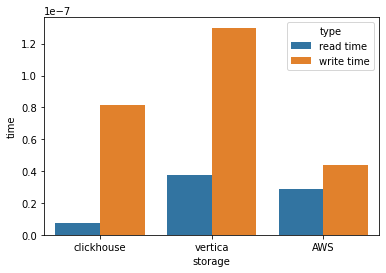

In [9]:
measurements = pd.DataFrame(
    list(zip(
        ['clickhouse', 'vertica', 'AWS'], 
        [7.5e-9, vertica_write_time.average, 2.9e-8],
        [8.14e-8, 1.3e-7, 4.4e-8],
    )),
    columns =['storage', 'read time', 'write time']
)
melted_measurements = measurements.melt(id_vars='storage').rename(columns={'value': 'time', 'variable': 'type'})
sns.barplot(x='storage', y='time', hue='type', data=melted_measurements)

## Схемы хранения и обработки данных в разных хранилищах

Не стоит недооценивать мощь джупитера. Он способен даже рисовать схемы на базе plantUML. Не без помощи библиотек, конечно)<br>
Для этого нужно поставить модуль `iplantuml`:

In [10]:
!!pip3.8 install iplantuml
None
# Если интересно - вот эти пляски с бубном (`!!`, `None`) можно применять, когда хочешь скрыть вывод ячейки.
# Обычно хватает просто None в последней строке, но у нас сложный случай - shell-команда. 
# dev/null не поможет, в него улетает не всё.
# Сначала конвертим вывод в список при помощи `!!`, а затем маскируем его при помощи None

In [11]:
import iplantuml

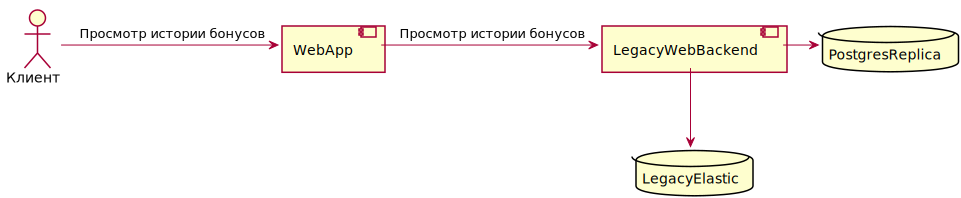

In [12]:
%%plantuml

@startuml
skinparam componentStyle uml2
actor Клиент as Client
component WebApp
component LegacyWebBackend
database PostgresReplica
database LegacyElastic

Client -> WebApp: Просмотр истории бонусов
WebApp -> LegacyWebBackend: Просмотр истории бонусов
LegacyWebBackend -> PostgresReplica
LegacyWebBackend -down-> LegacyElastic
@enduml 

## Скрипты, которые загружают или генерируют данные в хранилища

Что самое приятное в python-блокнотике - так это возможность запихнуть весь необходимый код в один файл, при этом разделить его на осмысленные блоки при помощи обычного человечьего языка и красивой разметки внутри Markdown-ячеек.

Чтобы хранилище не задохнулось, если ячейку с загрузкой данных вызвать несколько раз, можно предусмотреть предварительную очистку.

# А еще...

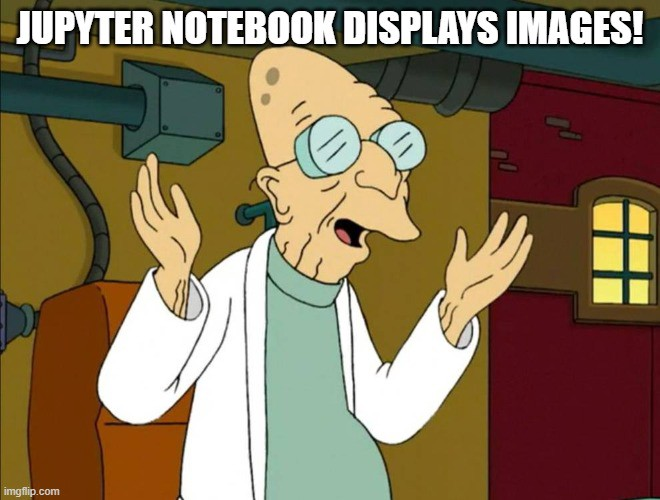

...и делает массу других вещей, например, позволяет выводить [интерактивные виджеты](https://medium.com/nuances-of-programming/%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5-%D1%83%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B2-jupyter-notebooks-4fd1fccb5788).<br>
Но об этом как-нибудь в другой раз :)